# Data Analysis on Avacado Prices #

In [99]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


1.13.1


In [ ]:
#Load the data into a Pandas Dataframe
df = pd.read_csv("Datasets/avacado/avocado.csv")
df.tail()

In [ ]:
#See if dataset needs cleaning
df.isna().sum()

In [ ]:
#Change categorical data of type to numerical
a_type = df.pop('type')
df['Organic'] = (a_type == 'organic')*1.0
df['Conventional'] = (a_type == 'conventional')*1.0

In [ ]:
#Check applied changes
print(df.head())
#See the unique regions 
df.region.unique()

In [ ]:
#Split data into training and testing
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)


In [ ]:
#Visualize pair plots
sns.pairplot(train_dataset[["AveragePrice", "Total Volume", "4046", "4225", "4770"]], diag_kind="kde")

In [ ]:
#Quick Facts about the data
train_stats = train_dataset.describe()
train_stats.pop("AveragePrice")
train_stats = train_stats.transpose()

test_stats = test_dataset.describe()
test_stats = test_stats.transpose()
test_stats

In [ ]:
# Labeled Data
train_labels = train_dataset.pop('AveragePrice')
test_labels = test_dataset.pop('AveragePrice')

In [ ]:
train_dataset.pop('Date')
test_dataset.pop('Date')

In [ ]:
#Fixthe data types
train_dataset['Unnamed: 0'] = train_dataset['Unnamed: 0'].astype(float)
train_dataset['year'] = train_dataset['year'].astype(float)
test_dataset['Unnamed: 0'] = test_dataset['Unnamed: 0'].astype(float)
test_dataset['year'] = test_dataset['year'].astype(float)
train_dataset.pop('region')
test_dataset.pop('region')
print(train_dataset.dtypes, train_stats.dtypes)

In [112]:
#Normalize the data
def norm_train(x):
  return (x - train_stats['mean']) / train_stats['std']
def norm_test(x):
  return (x - test_stats['mean']) / test_stats['std']
normed_train_data = norm_train(train_dataset)
normed_test_data = norm_train(test_dataset)

# Machine Learning # 

In [100]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [102]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                832       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 5,057
Trainable params: 5,057
Non-trainable params: 0
_________________________________________________________________


In [103]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.16811821],
       [ 0.10438229],
       [-0.02499139],
       [-0.14285386],
       [-0.21852148],
       [-0.0705817 ],
       [-0.157819  ],
       [-0.02701379],
       [-0.08513919],
       [ 0.17541099]], dtype=float32)

In [104]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])

Instructions for updating:
Use tf.cast instead.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................

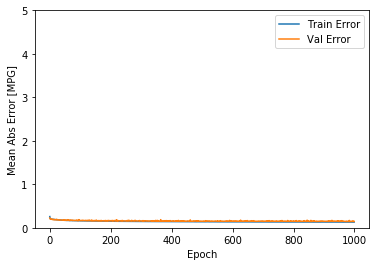

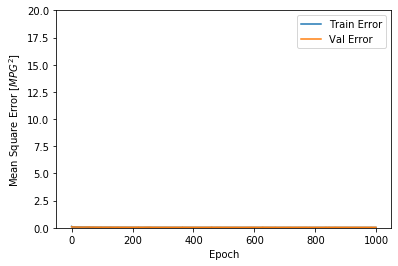

In [105]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)


..................................................................................

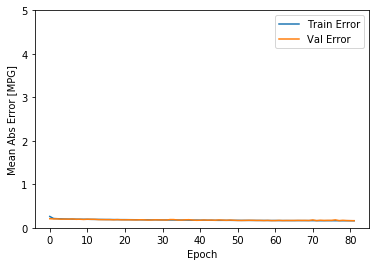

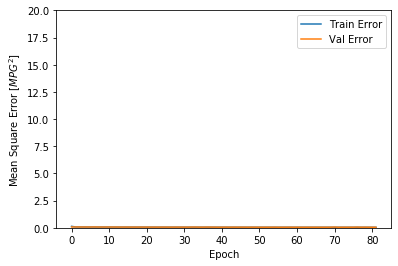

In [106]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [113]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Dollars".format(mae))

Testing set Mean Abs Error:  0.16 Dollars


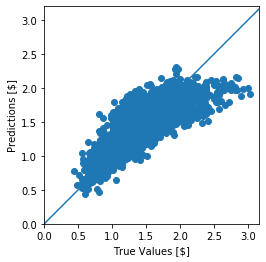

In [115]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [$]')
plt.ylabel('Predictions [$]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

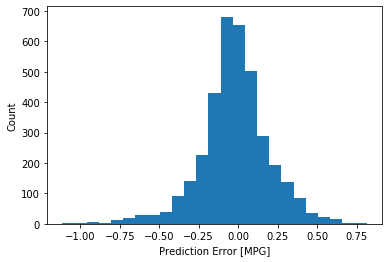

In [116]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")